In [347]:
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesScalerMinMax
from sklearn.preprocessing import StandardScaler

In [348]:
def moving_avg(x, N=1000):
    return np.convolve(x, np.ones((N,))/N, mode='valid')

Initializing variables and reading datasets

In [349]:
dsets = []
accelpedal = []
driverdem = []
engtorque = []
path = r'Final_engine_sys_data'

In [350]:
og = pd.read_csv('engine_system.csv')
q = og['61443-91'].quantile(q=0.80)
print('80th Percentile: ' + str(q))

80th Percentile: 60.0


In [351]:
for i in range(32):
    dsets.append(pd.read_csv(path + '\\final_engine_dset_' + str(i)+'.csv'))            #Moving averages are taken to smoothen the data
    dsets[i] = dsets[i][dsets[i] > q]
    dsets[i].dropna(inplace=True)
    vals = moving_avg(dsets[i]['61443-91'], 1000)
    accelpedal.append(vals[::100])
    vals = moving_avg(dsets[i]['61444-512'], 1000)
    driverdem.append(vals[::100])
    vals = moving_avg(dsets[i]['61444-513'], 1000)
    engtorque.append(vals[::100])

for i in range(6):
    dsets.append(pd.read_csv(path + '\\faulty_engine_dset_' + str(i)+'.csv'))
    dsets[32+i] = dsets[32+i][dsets[32+i] > q]
    dsets[32+i].dropna(inplace=True)
    vals = moving_avg(dsets[32+i]['61443-91'], 1000)                           #fix this
    accelpedal.append(vals[::100])
    vals = moving_avg(dsets[32+i]['61444-512'], 1000)
    driverdem.append(vals[::100])
    vals = moving_avg(dsets[32+i]['61444-513'], 1000)
    engtorque.append(vals[::100])

Reshape and format the datasets to be timeseries

In [352]:
formatted_pedal = to_time_series_dataset(accelpedal)
formatted_demand = to_time_series_dataset(driverdem)
formatted_torque = to_time_series_dataset(engtorque)
print("Accelerator Pedal Position Shape: " + str(formatted_pedal.shape))
print("Driver\'s Demand Torque Shape: " + str(formatted_demand.shape))
print("Actual Engine Torque Shape: " + str(formatted_torque.shape))

Accelerator Pedal Position Shape: (38, 111, 1)
Driver's Demand Torque Shape: (38, 111, 1)
Actual Engine Torque Shape: (38, 111, 1)


Plotting the timeseries

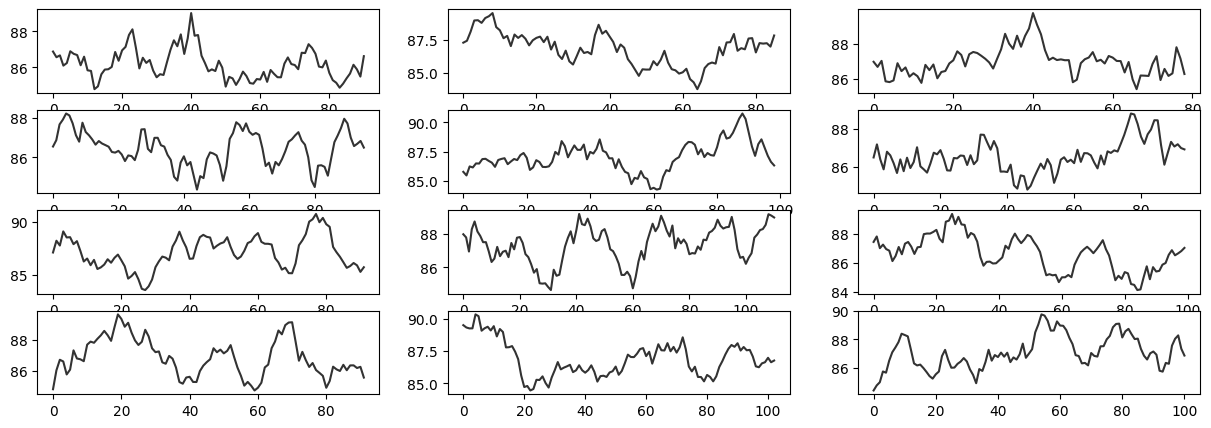

In [353]:
#Normal Accel Pedal
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_pedal[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

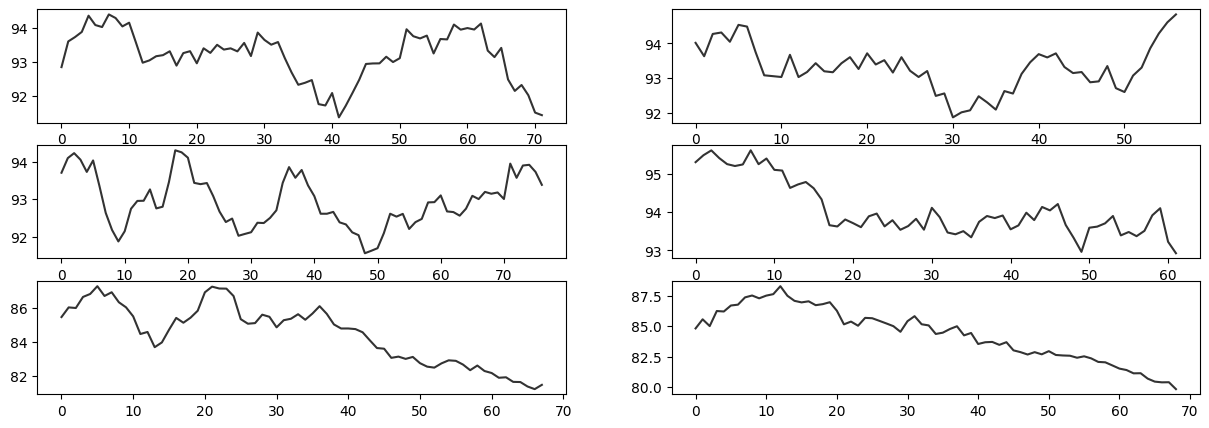

In [354]:
#Some Accel Pedal with Faults 
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_pedal[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

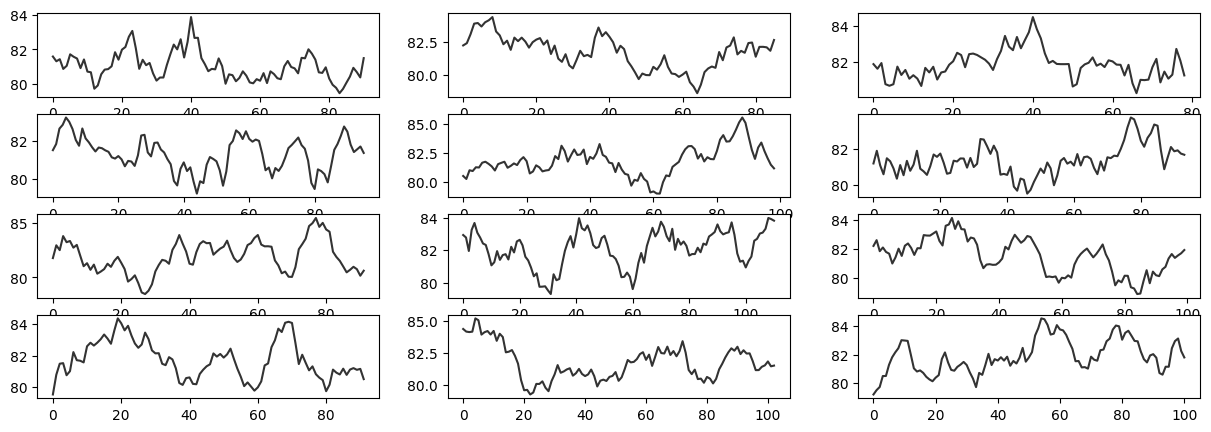

In [355]:
#Normal Driver's Demand
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_demand[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

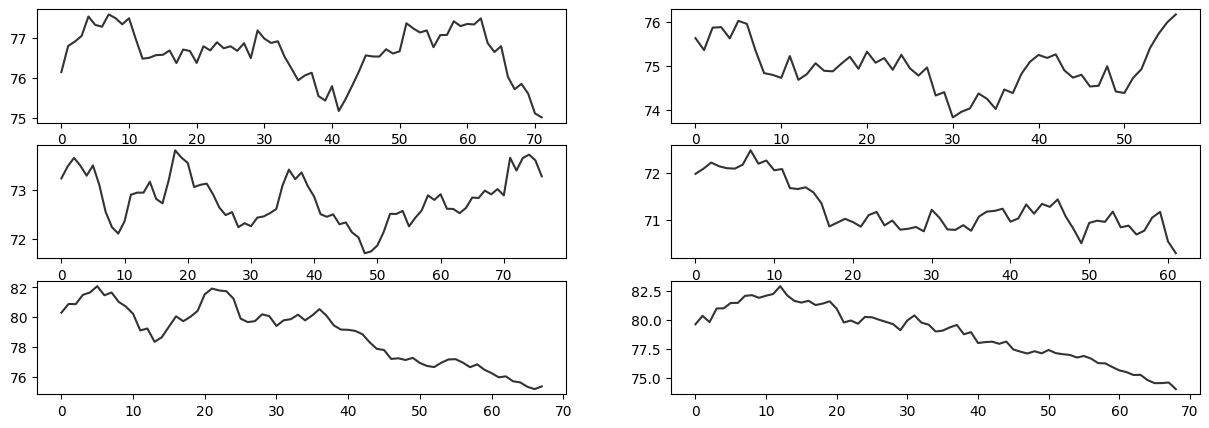

In [356]:
#Some Driver's Demand with Faults
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_demand[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

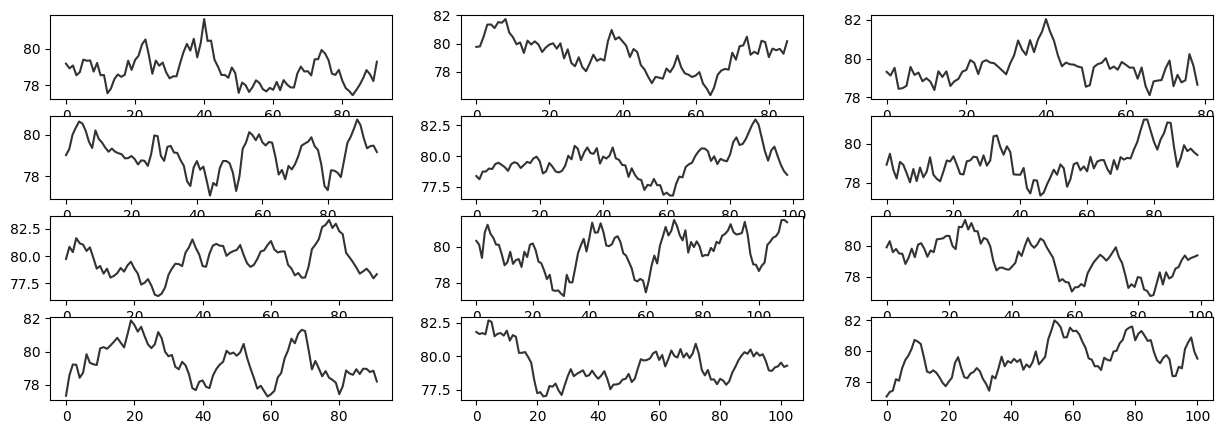

In [357]:
#Normal Actual Engine Torque
plt.figure(figsize=(15,5))
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(formatted_torque[yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

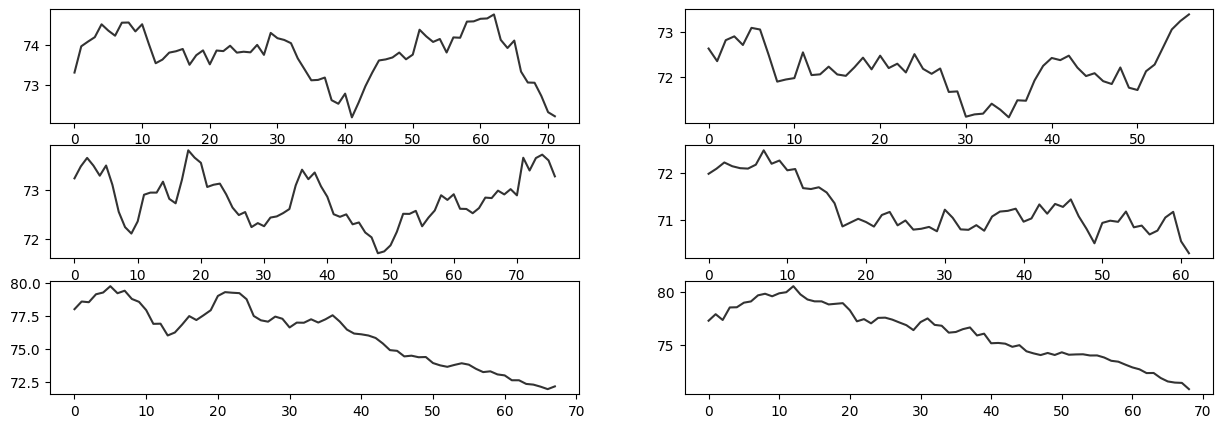

In [358]:
#Some Actual Engine with Faults 
plt.figure(figsize=(15,5))
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    plt.plot(formatted_torque[32+yi].ravel(), "k-", alpha=.8)
#     plt.text(0.55, 0.85,'Class Label: %d' % (y_train[yi]))

Checking Number of Clusters needed using the Elbow method and silhouette score

In [359]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=5,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_torque)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_torque)
    sil_score = silhouette_score(formatted_torque, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.8014926419472589
[33.3731021786258]
0.731298532248412
[33.3731021786258, 26.043747094156274]
0.22371591075495997
[33.3731021786258, 26.043747094156274, 20.78809826722835]
0.23990144059291338
[33.3731021786258, 26.043747094156274, 20.78809826722835, 18.683570643783845]
0.16455216606758677
[33.3731021786258, 26.043747094156274, 20.78809826722835, 18.683570643783845, 17.326509084678367]


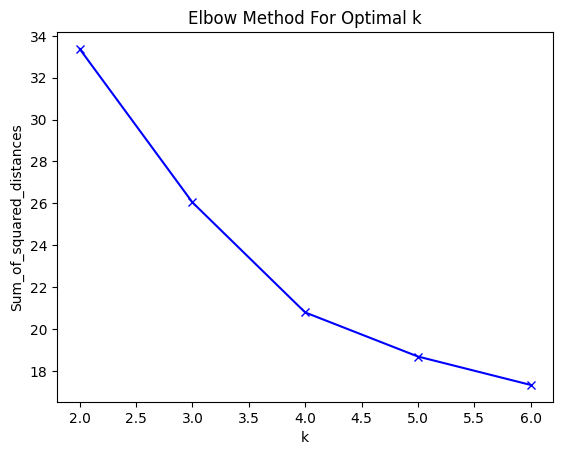

In [360]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for engine torque using DTW

DBA k-means
DBA silhoutte: 0.73
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[32 33 34 35]
[36 37]


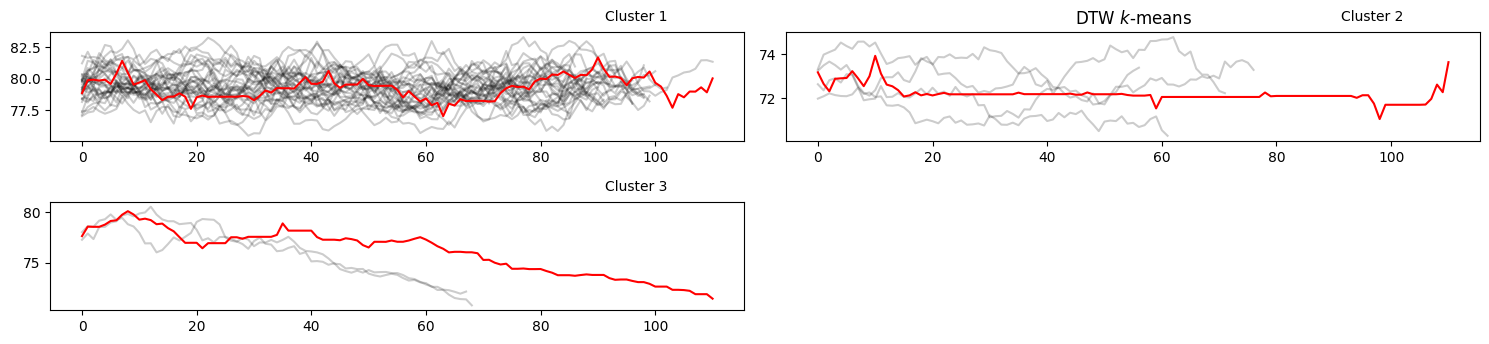

In [361]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=5,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_torque)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_torque, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_torque[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

    
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
print(np.where(y_pred_dba_km == 2)[0])

plt.tight_layout()
plt.show()

Checking clusters for Driver's Demand

In [362]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=5,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_demand)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_demand)
    sil_score = silhouette_score(formatted_demand, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.8262263196324681
[57.01666272113357]
0.7351210417497982
[57.01666272113357, 32.511856987166844]
0.6687168062018164
[57.01666272113357, 32.511856987166844, 28.042141632065505]
0.1687892008603954
[57.01666272113357, 32.511856987166844, 28.042141632065505, 22.559583633349604]
0.1913793004608199
[57.01666272113357, 32.511856987166844, 28.042141632065505, 22.559583633349604, 19.542083972651135]


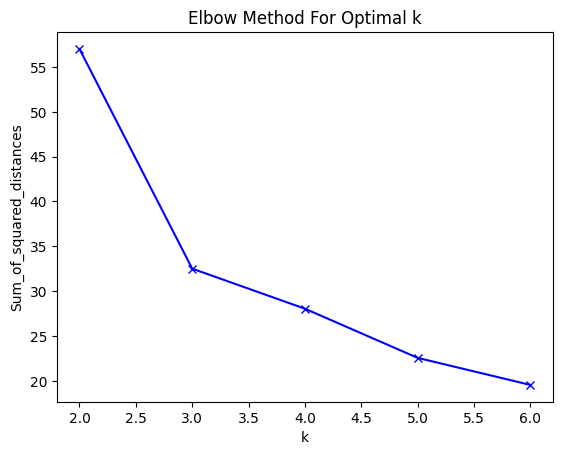

In [363]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for Driver's Demand using DTW

DBA k-means
DBA silhoutte: 0.74
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[34 35]
[32 33 36 37]


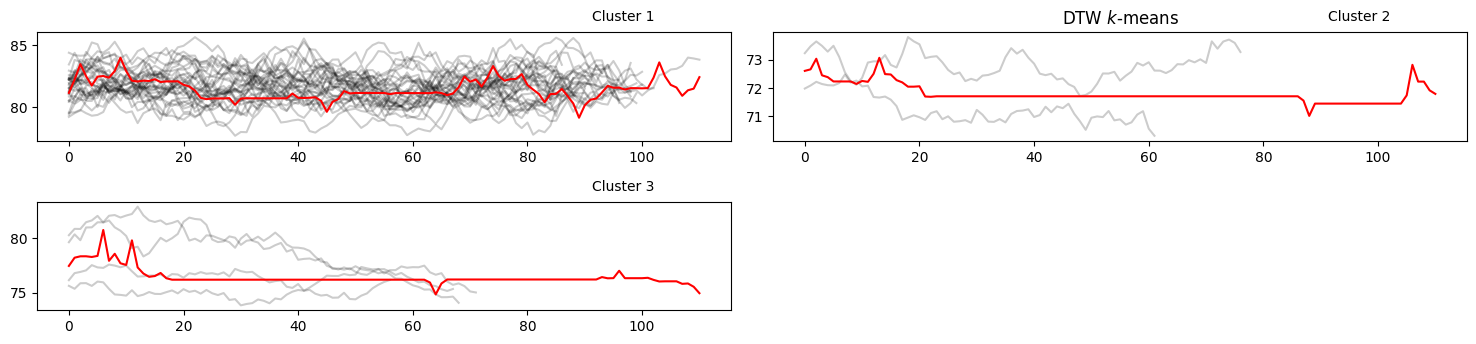

In [364]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=5,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_demand)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_demand, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(3):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_demand[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])
print(np.where(y_pred_dba_km == 2)[0])

plt.tight_layout()
plt.show()

Checking clusters for Accelerator Pedal Position

In [365]:
Sum_of_squared_distances = []
K = range(2,7)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=5,
                          metric="dtw",
                          random_state=42,
                          n_jobs=-1)
    
    km = km.fit(formatted_pedal)
    Sum_of_squared_distances.append(km.inertia_)
    preds = km.predict(formatted_pedal)
    sil_score = silhouette_score(formatted_pedal, preds, metric="dtw", n_jobs=-1)
    print(sil_score)
    print(Sum_of_squared_distances)

0.8489503735822667
[38.121370566718575]
0.6531935448423418
[38.121370566718575, 27.730499505477102]
0.23793730275053926
[38.121370566718575, 27.730499505477102, 21.575543144540756]
0.24911965810365408
[38.121370566718575, 27.730499505477102, 21.575543144540756, 18.44818467877254]
0.1953463982145054
[38.121370566718575, 27.730499505477102, 21.575543144540756, 18.44818467877254, 17.806361884772482]


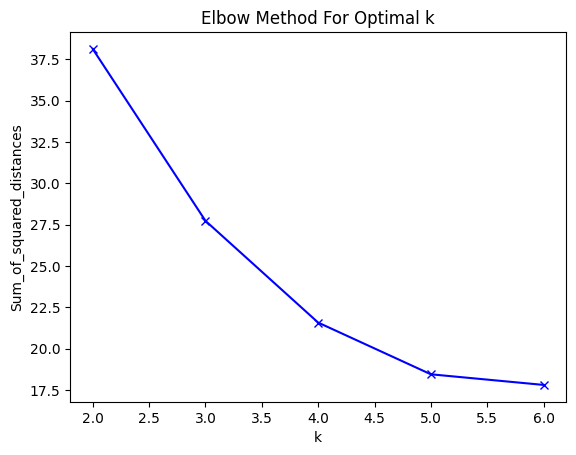

In [366]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Clustering for accelerator pedal position using DTW

DBA k-means
DBA silhoutte: 0.65
[32 33 34 35]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


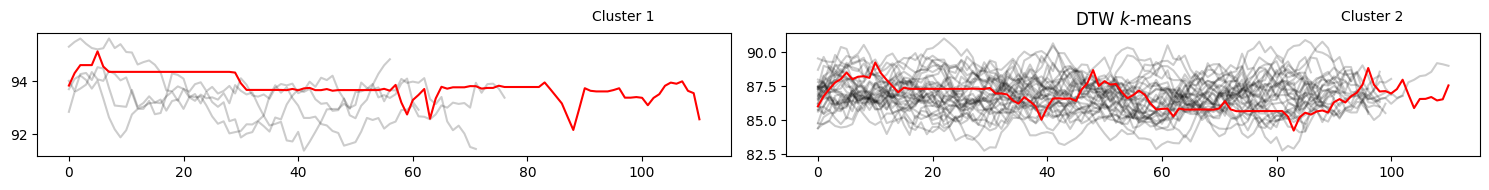

In [367]:
# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=3,
                          n_init=5,
                          metric="dtw",
                          verbose=False,
                          random_state=42)
y_pred_dba_km = dba_km.fit_predict(formatted_pedal)
print("DBA silhoutte: {:.2f}".format(silhouette_score(formatted_pedal, y_pred_dba_km, metric="dtw")))
plt.figure(figsize=(15,5))
for yi in range(2):
    plt.subplot(3, 2, yi+1)
    for xx in formatted_pedal[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.8, 1.1,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")
        
print(np.where(y_pred_dba_km == 0)[0])
print(np.where(y_pred_dba_km == 1)[0])

plt.tight_layout()
plt.show()